In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from GetCars import *
from CarModelClass import *

%matplotlib inline

def create_ROC_Curves(y, ypred, classes=[1,2,3]):
    fpr = dict()
    tpr = dict()
    auc_value = dict()
    y_true_bin = label_binarize(y, classes)
    labels = {
        1: "ROC Curve for Convertibles",
        2: "ROC Curve for Sedans",
        3: "ROC Curve for SUVs/Trucks/Vans",
        4: "ROC Curve for Trucks",
        5: "ROC Curve for Vans"
    }
    
    if len(classes)>3:
        labels[3] = "ROC Curve for SUVs"
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:,i], ypred[:,i])
        auc_value[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=labels[i+1]+" (area = {:.2f})".format(auc_value[i]),
                 linestyle = ":", lw=3)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.legend(loc="lower right", fontsize=15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("Multi-class ROC for Classifying Car Images: One class vs Rest", fontsize = 18)
    plt.show()

In [58]:
import numpy as np
import pandas as pd

import os, glob, re, scipy.io
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
    

###############################################################################
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.utils.multiclass import unique_labels

###############################################################################
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
# Pretrained
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_ppi
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_ppi
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as Res50V2_ppi
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inceptv3_ppi
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as moblv2_ppi
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inceptres_ppi
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as xcept_ppi
###############################################################################
from GetCars import *

PRETRAINED_MODELS = {
    'VGG16': {
        'model': VGG16,
        'preprocess': vgg16_ppi,
        'shape': (224, 224)
    },
    'VGG19': {
        'model': VGG19,
        'preprocess': vgg19_ppi,
        'shape': (224, 224)
    },
    'ResNet50V2': {
        'model': ResNet50V2,
        'preprocess': Res50V2_ppi,
        'shape': (224, 224)
    },
    'InceptionV3': {
        'model': InceptionV3,
        'preprocess': inceptv3_ppi,
        'shape': (299, 299)
    },
    'MobileNetV2': {
        'model': MobileNetV2,
        'preprocess': moblv2_ppi,
        'shape': (224, 224)
    },
    'InceptionResNetV2': {
        'model': InceptionResNetV2,
        'preprocess': inceptres_ppi,
        'shape': (299, 299)
    },
    'Xception': {
        'model': Xception,
        'preprocess': xcept_ppi,
        'shape': (299, 299)
    }
}


class cars_model_class():
    def __init__(self, cnn="MobileNetV2", no_of_classes = 3, path=""):
        if cnn in PRETRAINED_MODELS.keys():
            self.cnn = cnn
        self.no_of_classes = no_of_classes
        self.features_file = path + "" + self.cnn + ".csv"
        self.target_labels_file = path + "devkit/cars_labels_train_test.csv"
        
        self.get_data()
    
    def get_data(self):
        features_df = pd.read_csv(self.features_file)
        targets_df = pd.read_csv(self.target_labels_file)
        
        if self.no_of_classes == 3:
            target_column = "Label1_No"
            target_labels = "Label1"
        elif self.no_of_classes == 5:
            target_column = "Label2_No"
            target_labels = "Label2"
        else:
            target_column = "class_no"
            target_labels = "class_label"
            
        self.train_test = np.array(targets_df.loc[:,'trn0tst1'])
        
        self.Xtrain = features_df[ self.train_test == 0 ].iloc[:,2:]
        self.xtest = features_df[ self.train_test == 1 ].iloc[:,2:]
        self.Xtrain_fileName = features_df[ self.train_test == 0 ].iloc[:,1]
        self.xtest_fileName = features_df[ self.train_test == 1 ].iloc[:,1]
        
        self.Ytrain = targets_df[ self.train_test == 0 ][target_column]
        self.ytest = targets_df[ self.train_test == 1 ][target_column]
        
    def make_model():
        pass
    
    def build_misclass_df(self, ypred_lbls, ypred_proba):
        temp_ytrue_preds = np.append(np.array(self.ytest).reshape(-1, 1), ypred_lbls.reshape(-1, 1), axis=1)
        temp_y_wpred_proba = np.append(temp_ytrue_preds, ypred_proba, axis=1)
        temp_fileNames = np.array(self.xtest_fileName).reshape(-1, 1)
        temp_array = np.append(temp_fileNames, temp_y_wpred_proba, axis=1)
        
        cols = ["fileName", "ytrue_lbl", "ypred_lbl"] + [str(i) for i in range(1, self.no_of_classes + 1)]
        
        test_wPreds_df = pd.DataFrame(temp_array, columns=cols)
        
        return test_wPreds_df
    
    def get_misclass_topFileNames(self, ypred_lbls, ypred_proba, ytrue, yfalse, number_of_imgs=10, top=True):
        df_wpreds = self.build_misclass_df(ypred_lbls, ypred_proba)
        
        fileNames_df = df_wpreds[(df_wpreds['ytrue_lbl']==float(ytrue)) & ((df_wpreds["ypred_lbl"])==float(yfalse))]
        if top:
            fileNames_df.sort_values(str(int(yfalse)), ascending=False, inplace=True)
        else:
            fileNames_df.sort_values(str(int(yfalse)), ascending=True, inplace=True)

        no_of_misclass = fileNames_df.shape[0]
        
        to_return = number_of_imgs
        if no_of_misclass == 0:
            to_return = 0
        elif no_of_misclass < number_of_imgs:
            to_return = no_of_misclass
        
        fileNames_to_return = np.array(fileNames_df['fileName'].head(to_return))
        
        return fileNames_to_return

In [59]:
cars_model = cars_model_class(cnn="VGG19", no_of_classes=5)   
Xtrn = cars_model.Xtrain
xtst = cars_model.xtest
Ytrn = cars_model.Ytrain
ytst = cars_model.ytest

cars_PCA = PCA(n_components=500)
Xtrn_500 = cars_PCA.fit_transform(Xtrn)
xtst_500 = cars_PCA.transform(xtst)
print(np.sum(cars_PCA.explained_variance_ratio_))

logreg = LogisticRegression(C=0.01, verbose=True, solver="saga", max_iter=1000, multi_class="multinomial") # C: Inverse of regularization strength; 
logreg.fit(Xtrn_500, Ytrn)

0.8940983819046499


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 179 seconds


C:\Users\Howlw\anaconda3\envs\py3_TF2\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=True,
                   warm_start=False)

Train Score for the Logit Model: 0.775
Test Score for the Logit Model: 0.734
F1 score for logistic regression: 0.758224195917235
Confusion matrix: 

 [[856 250  43   6   3]
 [238 641  57   3   7]
 [ 23  70 436  39  24]
 [  5   2  43 276   5]
 [  4  14  19   5 168]]


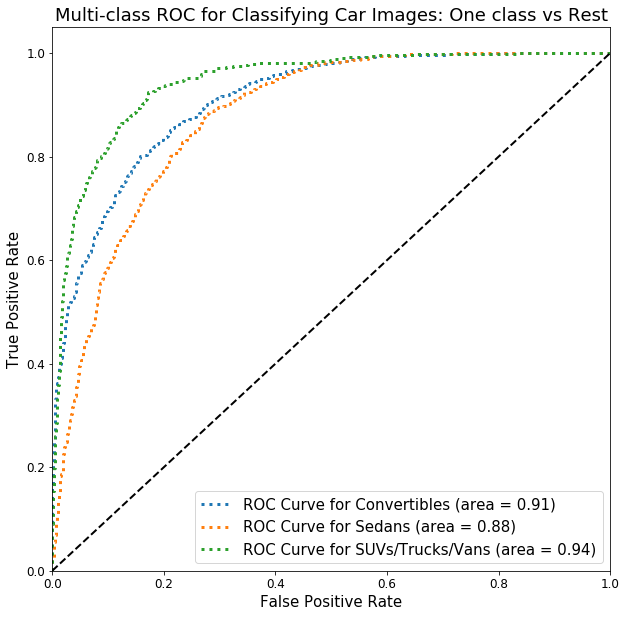

In [60]:
ytest_labels = logreg.predict(xtst_500)
ytest_prob = logreg.predict_proba(xtst_500)
train_score = logreg.score(Xtrn_500, Ytrn)
test_score = logreg.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score))
print("Test Score for the Logit Model: {:.3f}".format(test_score))
print("F1 score for logistic regression: {}".format(f1_score(ytst, ytest_labels, average="macro")))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytest_labels))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytest_prob)

C:\Users\Howlw\anaconda3\envs\py3_TF2\lib\site-packages\ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


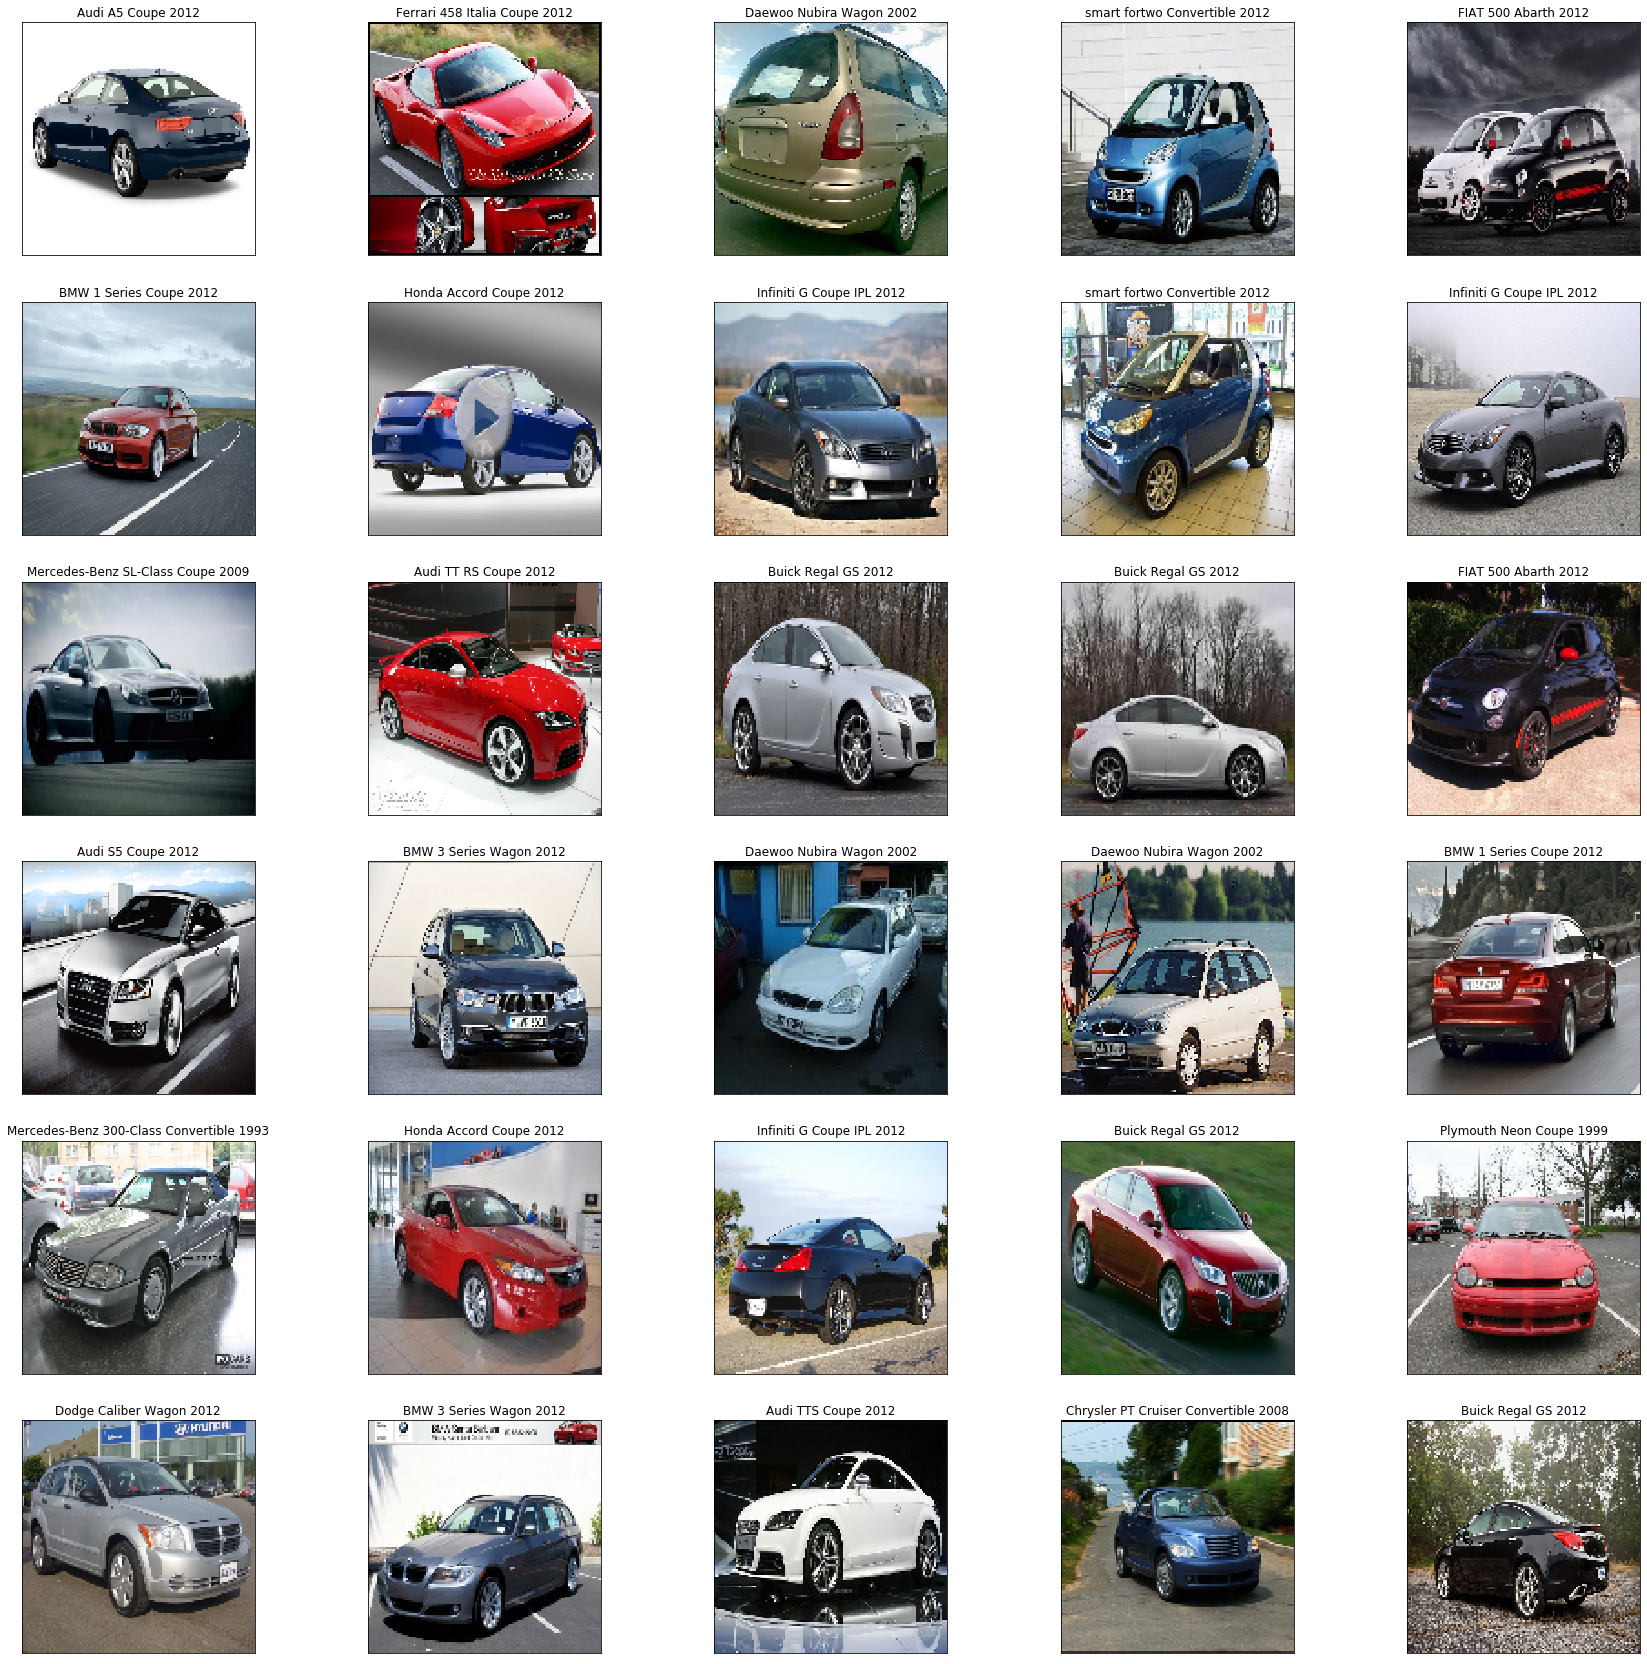

In [61]:
top20_12 = cars_model.get_misclass_topFileNames(ytest_labels, ytest_prob, 1, 2, 30, top=True)
GetCars().show_select_images(top20_12)

In [62]:
randomforest = RandomForestClassifier(n_estimators=500, max_depth=10, random_state = 333)
randomforest.fit(Xtrn_500, Ytrn)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=333,
                       verbose=0, warm_start=False)

Train Score for the Logit Model: 0.889
Test Score for the Logit Model: 0.633
F1 score for logistic regression: 0.6078897711685702
Confusion matrix: 

 [[930 209  18   1   0]
 [385 540  21   0   0]
 [ 91 148 346   6   1]
 [ 68  15  87 161   0]
 [ 52  45  39   2  72]]


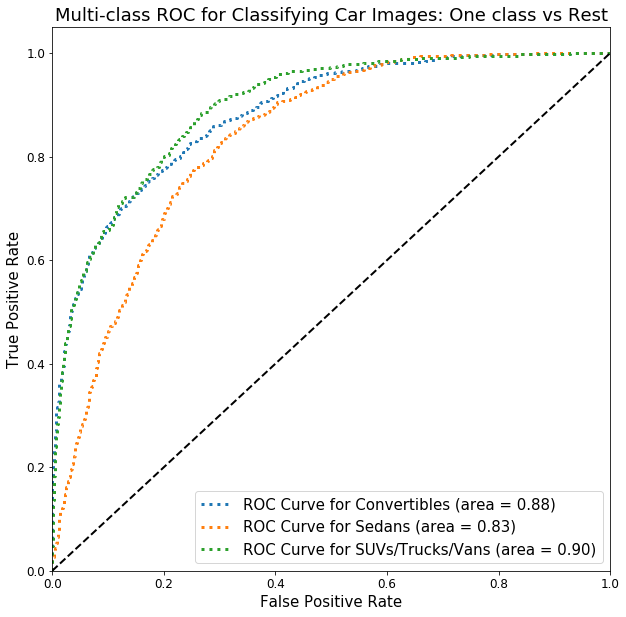

In [63]:
ytl_rf = randomforest.predict(xtst_500)
ytp_rf = randomforest.predict_proba(xtst_500)
train_score_rf = randomforest.score(Xtrn_500, Ytrn)
test_score_rf = randomforest.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score_rf))
print("Test Score for the Logit Model: {:.3f}".format(test_score_rf))
print("F1 score for logistic regression: {}".format(f1_score(ytst, ytl_rf, average="macro")))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytl_rf))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytp_rf)

In [64]:
cars_svc = SVC(kernel='poly', gamma='auto', probability=True, verbose=True)
cars_svc.fit(Xtrn_500, Ytrn)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)

Train Score for the Logit Model: 1.000
Test Score for the Logit Model: 0.737
F1 score for logistic regression: 0.7607346232746982
Confusion matrix: 

 [[841 270  39   6   2]
 [218 681  41   2   4]
 [ 33  72 432  37  18]
 [  4   7  45 274   1]
 [  4  23  23   3 157]]


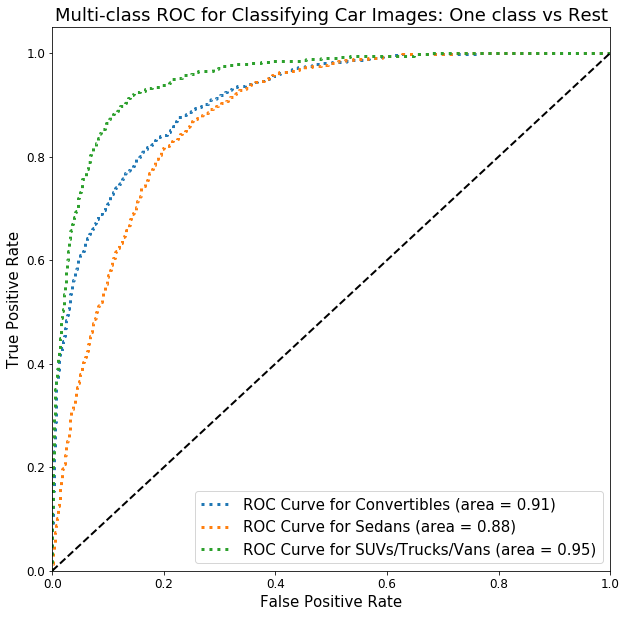

In [65]:
ytl_svc = cars_svc.predict(xtst_500)
ytp_svc = cars_svc.predict_proba(xtst_500)
train_score_svc = cars_svc.score(Xtrn_500, Ytrn)
test_score_svc = cars_svc.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score_svc))
print("Test Score for the Logit Model: {:.3f}".format(test_score_svc))
print("F1 score for logistic regression: {}".format(f1_score(ytst, ytl_svc, average="macro")))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytl_svc))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytp_svc)

In [66]:
dump(logreg, "Models/VGG19/LogReg_wPCA_Model2_5Class.joblib")
dump(cars_svc, "Models/VGG19/SVC1_wPCA_Model2_5Class.joblib")
dump(randomforest, "Models/VGG19/RFq_wPCA_Model2_5Class.joblib")

['Models/VGG19/RFq_wPCA_Model2_5Class.joblib']

In [67]:
cars_model = cars_model_class(cnn="VGG19", no_of_classes=5)   
Xtrn = cars_model.Xtrain
xtst = cars_model.xtest
Ytrn = cars_model.Ytrain
ytst = cars_model.ytest

cars_PCA = PCA(n_components=500)
Xtrn_500 = cars_PCA.fit_transform(Xtrn)
xtst_500 = cars_PCA.transform(xtst)
print(np.sum(cars_PCA.explained_variance_ratio_))

0.8940901752493415


Train Score for the Logit Model: 0.732
Test Score for the Logit Model: 0.716
F1 score for logistic regression: 0.7383534629587262
Confusion matrix: 

 [[833 266  48   7   4]
 [249 630  56   5   6]
 [ 25  73 422  42  30]
 [  5   2  46 273   5]
 [  7  15  20   7 161]]


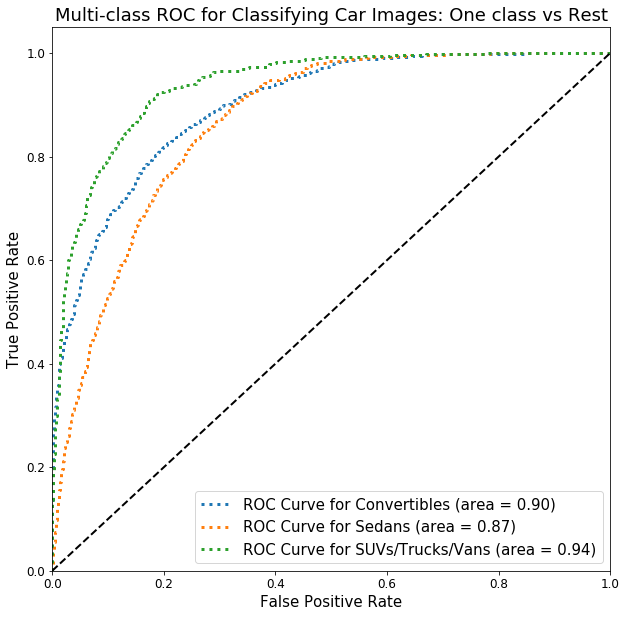

In [68]:
logreg = load("Models/VGG19/LogReg_wPCA_Model2_5Class.joblib")
ytest_labels = logreg.predict(xtst_500)
ytest_prob = logreg.predict_proba(xtst_500)
train_score = logreg.score(Xtrn_500, Ytrn)
test_score = logreg.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score))
print("Test Score for the Logit Model: {:.3f}".format(test_score))
print("F1 score for logistic regression: {}".format(f1_score(ytst, ytest_labels, average="macro")))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytest_labels))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytest_prob)

C:\Users\Howlw\anaconda3\envs\py3_TF2\lib\site-packages\ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


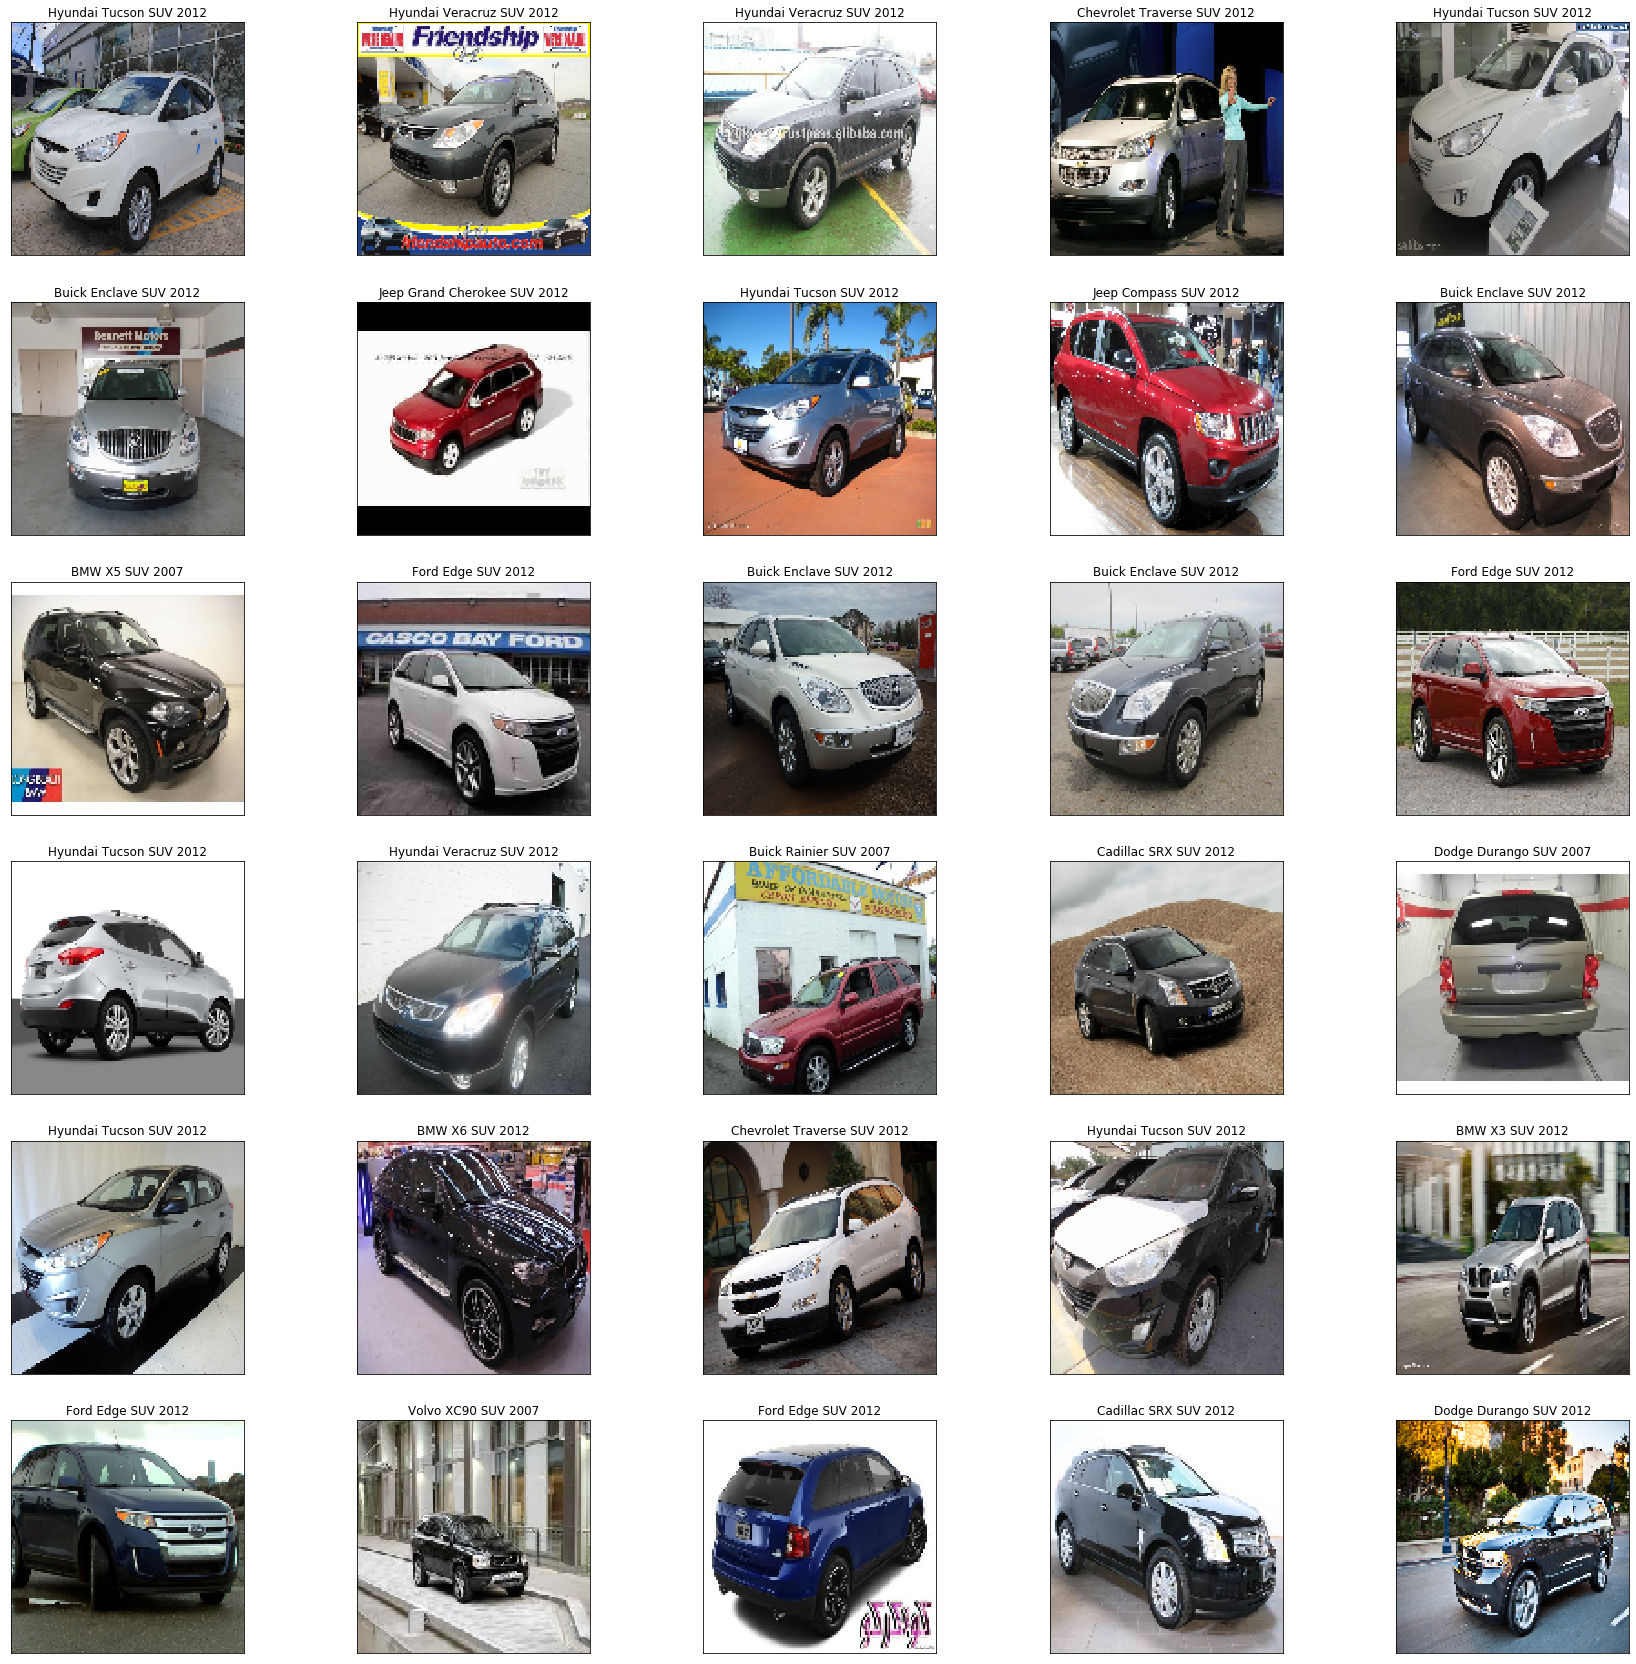

In [69]:
top20_12 = cars_model.get_misclass_topFileNames(ytest_labels, ytest_prob, 3, 2, 30)
GetCars().show_select_images(top20_12)

In [70]:
cars_model = cars_model_class(cnn="VGG19", no_of_classes=5)   
Xtrn = cars_model.Xtrain
xtst = cars_model.xtest
Ytrn = cars_model.Ytrain
ytst = cars_model.ytest

cars_PCA = PCA(n_components=500)
Xtrn_500 = cars_PCA.fit_transform(Xtrn)
xtst_500 = cars_PCA.transform(xtst)
print(np.sum(cars_PCA.explained_variance_ratio_))

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X500_S1, y_S1 = ros.fit_sample(Xtrn_500, Ytrn)

0.8940820600793165


In [1]:
logreg_S1 = LogisticRegression(C=0.01, verbose=True, solver="saga", multi_class = "multinomial", max_iter=1000) # C: Inverse of regularization strength; 
logreg_S1.fit(Xtrn_500, Ytrn)

ytest_labels_lrS1 = logreg_S1.predict(xtst_500)
ytest_prob_lrS1 = logreg_S1.predict_proba(xtst_500)
train_score_lrS1 = logreg_S1.score(Xtrn_500, Ytrn)
test_score_lrS1 = logreg_S1.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score_lrS1))
print("Test Score for the Logit Model: {:.3f}".format(test_score_lrS1))
print("F1 score for logistic regression: {}".format(f1_score(ytst, ytest_labels_lrS1, average="macro")))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytest_labels_lrS1))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytest_prob_lrS1, classes=[1, 2, 3, 4, 5])

NameError: name 'LogisticRegression' is not defined

In [2]:
randomforest_S1 = RandomForestClassifier(n_estimators=500, max_depth=10, random_state = 333)
randomforest_S1.fit(X500_S1, y_S1)

ytest_labels_rfS1 = randomforest_S1.predict(xtst_500)
ytest_prob_rfS1 = randomforest_S1.predict_proba(xtst_500)
train_score_rfS1 = randomforest_S1.score(Xtrn_500, Ytrn)
test_score_rfS1 = randomforest_S1.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score_rfS1))
print("Test Score for the Logit Model: {:.3f}".format(test_score_rfS1))
print("F1 score for logistic regression: {}".format(f1_score(ytst, ytest_labels_rfS1, average="macro")))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytest_labels_rfS1))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytest_prob_rfS1, classes=[1, 2, 3, 4, 5])

NameError: name 'RandomForestClassifier' is not defined